In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
from IPython.display import Image

<h1 style="text-align:center">Yelp Brunch Analysis Summary </h1>
<h4 style="text-align:right">Yunwen Jiang, Yueting Tang, Yunbei Zheng </h4>

### 1.Introduction and Data Cleaning
#### 1.1 Motivation & Thesis Statements
This analysis project mainly focuses on two goals. For goal1, we want to provide data-driven, actionable suggestions to Yelp brunch/breakfast business owners. Suggestions are based on two aspects: business attributes and reviews. For goal2, we constructed a regularized logistic regression model to predict star ratings on test set.
#### 1.2 Data Overview
We restricted all the businesses to brunch restaurants, selected by keywords "Breakfast" and "Brunch" but without tags like "Asian","Thai","Japanese"...
<br>As for these brunch restaurants we selected, the left barplot shows how many reviews there are for each rating level, while the right one shows how many businesses there are with repect to different stars. We can figure out more than 50k brunch businesses are rated as 4 stars and customers generously give 5-star comments to brunch clubs.
<table><tr>
    <td> <img src="../plots/stardistribution.jpeg" alt="Drawing" style="width: 150px;"/> </td>
    <td> <img src="../plots/stardistribution2.jpeg" alt="Drawing" style="width: 150px;"/> </td>
    </tr></table>

#### 1.3 Data Processing
1. Transformed emoticons into English words. Eg. ":)" to "happy"[1]
2. Expand abbreviation. Eg. "'m" to "am"
3. Convert text into lowercase.
4. Handle negation: add not_ to every word between negation and following punctuation.  
Eg. "The food did not taste good."  to "The food did not not_taste not_good."
5. Remove punctuation.
6. Lemmatize: reduce inflections or variant forms to base form
7. Remove unimportant words
8. Extract phrases. Eg. "french toast" to "french_toast"

### 2. Feature Extraction: TF-IDF

We used TFIDF scores in both review analysis and prediction model, so we introduce it first. TFIDF considers the number of all texts containing the word. It can reduce the impact of frequently appearing meaningless words and explore more meaningful features. By contrast, the more text items there are, the more significant TFIDF will be. Supposed that $t$ indicates a term and $d$ indicates a document, then the definition of TFIDF is:

$tf(t,d) =$number of times term t appears in document d  
$idf(t) =$number of documents in collection devided by number of documents that contain t  
$TFIDF score = tf(t,d) * idf(t)$
### 3.Suggestions Based on Business Attributes
In this part, we want to figure out which business attributes are most important to ratings and how they influence ratings. We extracted information of business attributes from raw data, used tree-method to rank business attributes with importance score and did nonparametric tests to check if the business attributes are statistically related to ratings.
#### 3.1 Data Processing and Model Fitting
We deleted business attributes with more than 80 percent missing values, and uniformed the value type. We retained 26 business attributes.  
We chose GBDT(Gradient Boosting Decison Tree) to build our model because it can handle missing values automatically. We got the importance score of 26 business attributes based on this model and ranked them. We selected the top 5 business attributes for future work. They are RestaurantsTableService, OutdoorSeating, BusinessParking, NoiseLevel, Caters.
#### 3.2 Hypothesis Testing
We checked if the top 5 business attributes are really related to ratings through nonparametric tests Kruskal–Wallis H test and Wilcoxon rank-sum test because our data aren't distributed normally. Kruskal-Wallis H test is used for testing whether samples originate from the same distribution and it can compare more than two samples. The null hypothesis is that the samples are the same distribution, and the alternative hypothesis is that at least one distribution of one sample is different from the distribution of at least one other sample. Wilcoxon rank-sum test is extended from Kruskal-Wallis H test and is used for testing only 2 samples.[2]

1. For business attributes that have only 2 categories, we applied Wilcoxon rank-sum test to see the exsitance of statistical difference between two categories.  If p-value < 0.05, the null hypothesis is rejected, we will choose it as a candidate.
2. For business attributes that have more than 2 categories, we first applied Kruskal test to see if there is some difference exsiting in the different levels. If p-value < 0.05, the null hypothesis is rejected, then we will do pairwise Wilcoxon test with Bonferroni correction to see the real difference among all the level pairs. Supposed that we have m tests and the overall alpha level is 0.05, we would test each individual hypothesis at a significance level of 0.05/m to control the familywise error rate.  

Through hypothesis tests, we found that the top 5 business attributes are statistically related to ratings. For NoiseLevel that has 4 levels, the ratings distribution of loud sample and very_loud sample are the same. 
#### 3.3 Suggestions
We examined the meanings of these business attributes and found that the definition of Caters is ambiguous. So we retained the remaining 4 business attributes. For each business attribute, we examined the average star ratings of each level, sorted them in descending order and picked the level of highest average star ratings as the ideal level.

### 4. Suggestions Based on Reviews contents
#### 4.1 Individual Words & Phrases 
##### 4.1.1 Words Distribution
Following are several TFIDF score distribution plots of typical food from the text, distributed by the stars. We can see some food have a similar trend which need further tests.

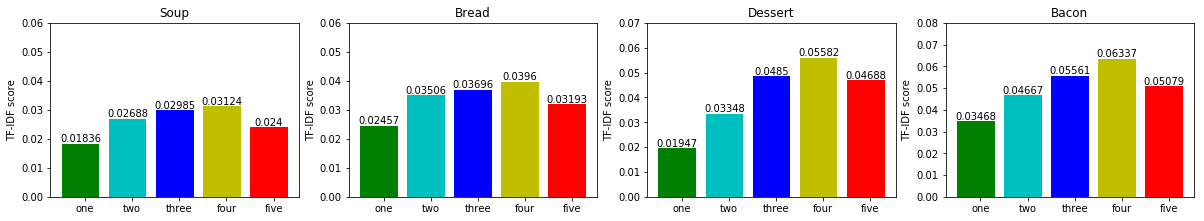

In [4]:
Image(filename="./output pictures/soup.png", width=400, height=40)

##### 4.1.2 Correlation test
We can see 'bread' and 'soup' / 'bacon' and 'dessert' seem to have a similar trend among different stars' reviews. To test whether there exists correlation between those two food items, we used Spearman's method to do the correlation test.  
Spearman rank correlation is a non-parametric test that is used to measure the degree of association between two variables. The assumptions of the Spearman correlation are that data must be at least ordinal and the scores on one variable must be monotonically related to the other variable.[3]. The null hypothesis is that the value of the association measure equals 0, which means the two samples are uncorrelated.  

The result is:  
bread & soup Spearman's rank correlation rho: p-value = 0.01667 < 0.1   
bacon & dessert Spearman's rank correlation rho: p-value = 0.01667 < 0.1  
All of the two hypotheses reject H0 at 90% significance level, so these two pairs of words are correlated with each other respectively. These food items do have a similar trend in their TF-IDF score.

#### 4.2 Topic Modelling
##### 4.2.1 LDA Model & Word2Vec Model
We have already explained and got the tfidf scores for each word before. Then we constructed Latent Dirichlet Allocation(LDA) model based on the tfidf scores. <br>LDA model is a “generative probabilistic model” of a collection of composites made up of parts[4]. It will finally give us two matrices, one is probabilities of parts given a specific topic, the other is probabilities of topics given a composite. Here composites refer to reviews and parts refer to words or phrases. And we use coherence score as the criteria to decide how many topics are best fitted.

<table><tr>
    <td> <img src="../plots/coh_score.png" alt="Drawing" style="width: 150px;"/> </td>
    <td> <img src="../plots/topicsum.png" alt="Drawing" style="width: 250px;"/> </td>
    </tr></table>

We kept the lda model with the highest coherence score for future use and that is the 15-topic model. Each topic is given in the format like ' 0.018*"taco" + 0.010*"burrito" + 0.009*"salsa" + 0.007*"carne_asada" + 0.005*"mexican_food" + 0.004*"chip_salsa" + 0.004*"bean" + 0.004*"guacamole" + 0.004*"tortilla" + 0.004*"fish_taco" ', where the parameters represent the weights of the specific words distributing to this topic. <br>We retained the keywords with weight greater than 0.002. And now we need to summarise these various keywords in each topic to a more general one with the help of synonym and similarity generated by Word2Vec model, which is also a word embedding model like tfidf, but it considers the context of a word[5].<br>Taking the 399,991th review as an example, we can see how the topic model works.<br>'long update_review az bread_company fantastic come move_arizona 
     freindliest people_work come hi remember cheerful 
     food general french_toast egg salad fondness green_chili 
     quiche particular come fast unique actually extremely quick bring_out food appear busy wind 
     bring niece_nephew child friendly_staff happy see take time see true_hidden gem glad house 
     green_chile quiche strawberry french_toast egg salad sandwich'

<td> <img src="../plots/screenshot.png" alt="Drawing" style="width:250px;"/> </td>

We can see that each topic has a score with repect to the correlation with the given review and these scores sum up to 1.<br>We then calculate the number of each topic in reviews with different stars and treat these accumulated scores as the times of appearances of each topic and use them for later barplotting and chi-square testing.

#### 4.2.2 Topic Distribution

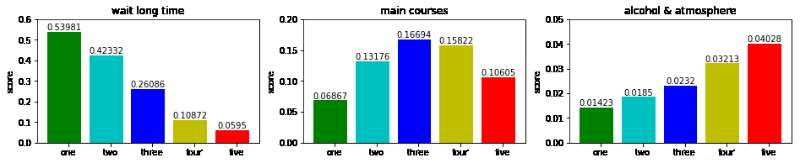

In [9]:
Image(filename="three box.jpeg",width=400, height=20)

##### 4.2.3 Chi-square Test
To test whether the topic model is useful for us, we picked up the top 13 topic words' groups to do Chi-square test.
<br>H0: The distribution of two data sets are independent, which means the distribution of reviews with these topic words is different from the distribution of reviews without those.
The table shows the topic score of whether or not the reviews of the restaurants have these words among different stars.

|-|star1 |star2 |star3 |star4 |star5|-|-|star1 |star2 |star3 |star4 |star5|
|-----|----|-----|------|-----|------|-|-----|----|-----|------|-----|------|
|coffee & good location|960.99 | 1328.28  |3496.24  | 8850.98 | 10998.81|-|wait time service| 1689.57 | 1284.75 | 1662.86|  2283.43 |  2997.66|
|not contain these|48794.01 |43068.72| 61121.76 |123230.02| 203835.19|-|not contain these|48065.43 |43112.25| 43112.25| 43112.25| 211836.34|

(left one) Chi-squared test for given probabilities:  X-squared = 2249.6, df = 4, p-value < 2.2e-16
<br>(right one) Chi-squared test for given probabilities: X-squared = 1287.8, df = 4, p-value < 2.2e-16
<br>Similarly, all of the top 13 topics are significant.

### 5. Suggestions
For business attributes, we propose following suggestions:  
Cancel the table service will increase the average rating by 0.18 stars; add some outdoor seats will increase the average rating by 0.24 stars; provide business parking place will increase the average star rating by 0.17 stars; provide a quitter environment will increase the average star rating by 0.09 to 0.38 stars.

For the reviews contents, suggestions are as below:  
1.Businesses do not need to pursue low price and good location, which only make you achieve average(around 3-4 stars), but not extraordinary.  
2.Regular food like burgers and sandwiches have no competitiveness for brunch restaurants(mode 3 stars), food especially for breakfast like pancakes, waffles and omeletes are better(mode 4 stars), but mexican style food like tacos and burritos are highly recommended.  
3.Instead of developing new types of food(seafood, banana pudding), providing delicate coffee and pastries helps you stand out(5 stars).  
4.Setting a bar with various kinds of alcohol and playing music are really good ideas to create happier atmosphere, which contributes a lot to the high ratings.  
5.Service is sooooo important and try to make the business less crowded and reduce the wait time.  

### 6. Regularized Logistic Regression Prediction Model
In this part, due to the limited memory of our computer, we randomly selected one million reviews as our training data, but it contained 87% business owners, so we thought that our data contained enough imformation. 
Based on the processed data mentioned before,we used TFIDF score to construct design matrix. We got the matrix with $1000000* 628798$ dimension.
We used SAGA, a fast stochastic optimization method usually used in large amount of data to optimize the cost function. To avoid overfiiting, we also added L2 penalty to our cost function. <br>
The RMSE on test set is 0.65552, which shows that our prediction model performs well. 

### 7. Contribution
Yunwen Jiang: Data processing, suggestions on business attributes, regularized logistic regression model
<br> Yueting Tang:Data visualization, Topic model by LDA, Word2Vec model
<br>Yunbei Zheng:Feature Extraction, Individual Words & Phrases, Topic Distribution, Chi-square Test

### Reference
[1] https://simple.wikipedia.org/wiki/List_of_emotions
<br>[2] https://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance, https://en.wikipedia.org/wiki/Mann–Whitney_U_test
<br>[3] https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/
<br>[4] https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
<br>[5] https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d
<br>[6] http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XKK2_C2ZPfZ
